# Qiskit Circuit Implementation

In [206]:


import numpy as np

from qiskit import execute, Aer, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import random_statevector, Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-23 13:19:41,331: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Original circuit

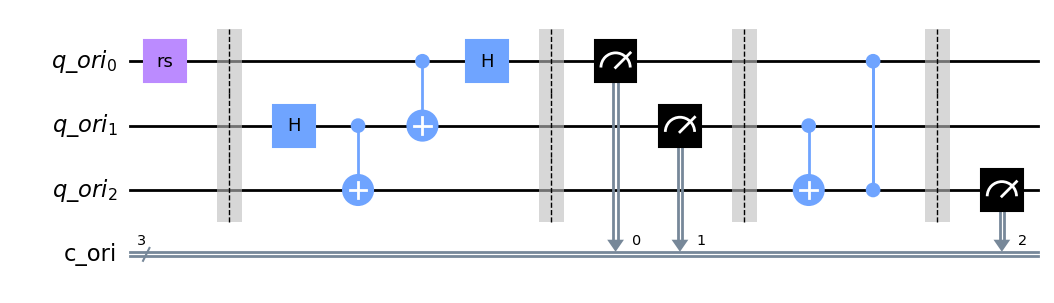

In [207]:


# Creating the quantum circuit
q_ori = QuantumRegister(3, 'q_ori')
c_ori = ClassicalRegister(3, 'c_ori')
qc_ori = QuantumCircuit(q_ori, c_ori, name='qc_ori')

# Inserting a random state in the first qubit
rs_circuit = QuantumCircuit(1, name='rs')
random_state = random_statevector(2)
rs_circuit.initialize(random_state.data, 0)
qc_ori.append(rs_circuit, [0])
qc_ori.barrier()

# Implementing the circuit
qc_ori.h(q_ori[1])
qc_ori.cx(q_ori[1], q_ori[2])

# Intra gate Teleportation
qc_ori.cx(q_ori[0], q_ori[1])
qc_ori.h(q_ori[0])
qc_ori.barrier()

# Measuring the qubits
qc_ori.measure(q_ori[0:2], c_ori[0:2])
qc_ori.barrier()

# Adding corrections
qc_ori.cx(q_ori[1], q_ori[2])
qc_ori.cz(q_ori[0], q_ori[2])
qc_ori.barrier()

# Measuring the third qubit
qc_ori.measure(q_ori[2], c_ori[2])

qc_ori.draw(output='mpl')

To test the original circuit we have to measure the probability of the output state to be $\ket{0}$ or $\ket{1}$ and compare it with the probability of the random state. If they match than the state has been correctly generated.

In [208]:

def prob_of_random_state(random_state: Statevector):
    prob_0 = np.abs(random_state[0]) ** 2
    prob_1 = np.abs(random_state[1]) ** 2

    return prob_0*100, prob_1*100

def prob_from_measurement(measurement: dict):
    total = sum(measurement.values())
    prob_0 = 0
    prob_1 = 0

    for key, value in measurement.items():
        if key[0] == '0':
            prob_0 += value
        else:
            prob_1 += value

    return prob_0 / total *100.0, prob_1 / total *100.0

def get_probabilities(qc: QuantumCircuit):
    ## Simulating the circuit
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)

    print("Probability of 0 and 1 from the measurement:")
    print("From the measurement : |0>: %.3f %%, |1>: %.3f %%" % prob_from_measurement(counts))
    print("From the random state: |0>: %.3f %%, |1>: %.3f %%" % prob_of_random_state(random_state))

In [209]:

get_probabilities(qc_ori)

Probability of 0 and 1 from the measurement:
From the measurement : |0>: 75.800 %, |1>: 24.200 %
From the random state: |0>: 75.432 %, |1>: 24.568 %


## Modified circuit

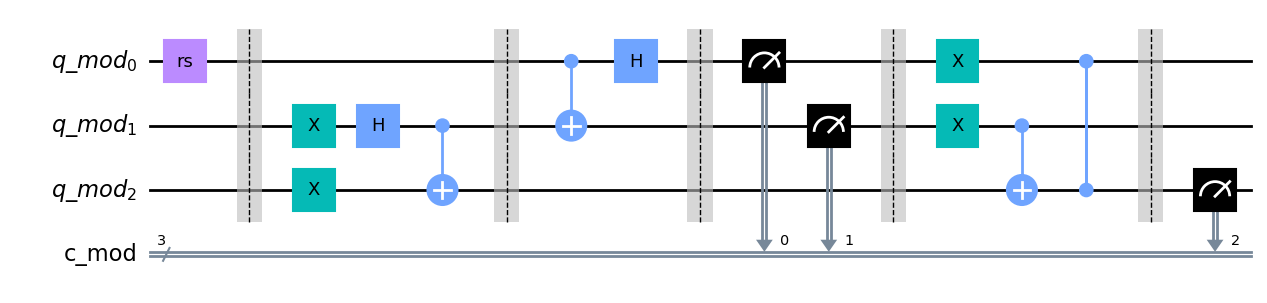

In [210]:


# Creating the quantum circuit
q_mod = QuantumRegister(3, 'q_mod')                     
c_mod = ClassicalRegister(3, 'c_mod')
qc_mod = QuantumCircuit(q_mod, c_mod, name='qc_mod')

# Inserting a random state in the first qubit
rs_circuit = QuantumCircuit(1, name='rs')           # Creating a circuit to insert a random state
random_state = random_statevector(2)                # Creating a random state
rs_circuit.initialize(random_state.data, 0)         # Initializing the circuit with the random state
qc_mod.append(rs_circuit, [0])                      # Appending the circuit to the main circuit
qc_mod.barrier()

# Creating Bell State 
qc_mod.x(q_mod[1])
qc_mod.x(q_mod[2])
qc_mod.h(q_mod[1])
qc_mod.cx(q_mod[1], q_mod[2])
qc_mod.barrier()

# Intra gate Teleportation
qc_mod.cx(q_mod[0], q_mod[1])
qc_mod.h(q_mod[0])
qc_mod.barrier()

# Measuring the qubits
qc_mod.measure(q_mod[0:2], c_mod[0:2])
qc_mod.barrier()

# Adding corrections
qc_mod.x(q_mod[0])
qc_mod.x(q_mod[1])
qc_mod.cx(q_mod[1], q_mod[2])
qc_mod.cz(q_mod[0], q_mod[2])
qc_mod.barrier()

# Measuring the third qubit
qc_mod.measure(q_mod[2], c_mod[2])

qc_mod.draw(output='mpl')

In [211]:

get_probabilities(qc_mod)

Probability of 0 and 1 from the measurement:
From the measurement : |0>: 83.400 %, |1>: 16.600 %
From the random state: |0>: 84.527 %, |1>: 15.473 %


As we can see from the circuit above, the only modification we did to the original circuit was to add the X gates when creating the Bell state and before the controlled X and Z gates.